In [1]:


# Imports
import collections
import os
import tarfile

from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm

from waymo_open_dataset.protos import scenario_pb2
from waymo_open_dataset.protos import sim_agents_submission_pb2
from waymo_open_dataset.utils import trajectory_utils
from waymo_open_dataset.utils.sim_agents import submission_specs
from waymo_open_dataset.utils.sim_agents import visualizations
from waymo_open_dataset.wdl_limited.sim_agents_metrics import metric_features
from waymo_open_dataset.wdl_limited.sim_agents_metrics import metrics

# Set matplotlib to jshtml so animations work with colab.
rc('animation', html='jshtml')
     


2025-06-01 22:25:30.100808: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 22:25:30.282190: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 22:25:30.284477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-01 22:25:31.558389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("CUDA version:", torch.version.cuda)


PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA device name: Tesla V100-PCIE-32GB
CUDA version: 11.7


In [9]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate real sine wave data
x_vals = np.linspace(0, 100, 1000)
data = np.sin(x_vals)

# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+1:i+seq_length+1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
X, Y = create_sequences(data, seq_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1).to(device)  # shape: (batch, seq_len, 1)
Y_tensor = torch.tensor(Y, dtype=torch.float32).unsqueeze(-1).to(device)


In [10]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate real sine wave data
x_vals = np.linspace(0, 100, 1000)
data = np.sin(x_vals)

# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+1:i+seq_length+1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
X, Y = create_sequences(data, seq_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1).to(device)  # shape: (batch, seq_len, 1)
Y_tensor = torch.tensor(Y, dtype=torch.float32).unsqueeze(-1).to(device)


Epoch 10/100, Loss: 0.092961
Epoch 20/100, Loss: 0.022660
Epoch 30/100, Loss: 0.010577
Epoch 40/100, Loss: 0.007080
Epoch 50/100, Loss: 0.006052
Epoch 60/100, Loss: 0.005240
Epoch 70/100, Loss: 0.004397
Epoch 80/100, Loss: 0.003776
Epoch 90/100, Loss: 0.003177
Epoch 100/100, Loss: 0.002643


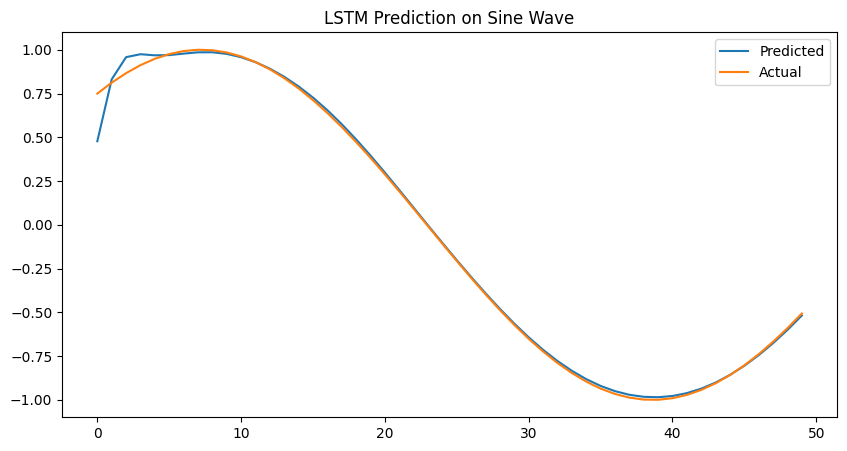

In [11]:

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.linear(out)
        return out

# Hyperparameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
learning_rate = 0.01
num_epochs = 100

# Initialize model, loss, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    model.train()
    output = model(X_tensor)
    loss = criterion(output, Y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

# Evaluate on the last sequence
model.eval()
with torch.no_grad():
    test_input = X_tensor[-1:].to(device)
    predicted = model(test_input).cpu().numpy().flatten()
    target = Y_tensor[-1:].cpu().numpy().flatten()

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(predicted, label='Predicted')
plt.plot(target, label='Actual')
plt.legend()
plt.title('LSTM Prediction on Sine Wave')
plt.show()
